# Mode Explorer
## 1. Dependencies:
* numpy
* cython
* matplotlib
* pyqt4
* pyo  #python setup.py install at the pyo directory. Please use the local directory for the custom fifo player



In [2]:
%load_ext Cython
import matplotlib.pyplot as plt
import numpy as np
import pyo
import math, time, random, threading


WxPython is not found for the current python version.
Pyo will use a minimal GUI toolkit written with Tkinter.
This toolkit has limited functionnalities and is no more
maintained or updated. If you want to use all of pyo's
GUI features, you should install WxPython, available here:
http://www.wxpython.org/



## 2. Description:
Based on Particle Trajectory Sonification. Sonify mode of high dimensional numerical data. Interact with GUI window.

## 3. Start a fifo player
This allows audio clips to be played on demand 'instantly'.

In [7]:
sr = 11025.
ser = pyo.Server(sr=int(sr), nchnls=1, buffersize=512)  # pyo server
ser.boot()
fifo = pyo.FIFOPlayer()
out = pyo.Biquad(fifo, freq=5000, q=1, type=0).out()  # BPF
s.start()

## 4. Core Method: Particle Trajectory Sonification

In [5]:
%%cython -2
cimport numpy as np
import numpy as np
from libc.stdlib cimport rand, malloc, free
from libc.math cimport exp

def potential(np.ndarray[np.float64_t, ndim=2] data,\
              np.ndarray[np.float64_t, ndim=1] pos,\
              double sigma=0.2):
    """Potential energy function. 
    
    Args:
      data (float64): your data 
      
      pos (float64): current position of the particle
      
      sigma (double): sigma attribute

    Returns:
      potential double : potential energy of the particle
    """
    cdef int N, dim, j, i
    cdef double potential, distsq, h
    cdef double minusOneOverTwoSigmaSquared = -0.5/(sigma*sigma)
    N, dim = data.shape[0], data.shape[1]
    for j in range(N):
        distsq = 0
        for i in range(dim): 
            h = pos[i] - data[j, i]
            distsq += h*h
        potential += -exp(minusOneOverTwoSigmaSquared * distsq)
    return potential

# trj, sig, lastpos, lastvel = PTSM(data, initialpos, initialvel, sigma, mass, r, dt, nrSteps)
def PTSM(np.ndarray[np.float64_t, ndim=2] data,\
         np.ndarray[np.float64_t, ndim=1] initialpos,\
         np.ndarray[np.float64_t, ndim=1] initialvel,\
         double sigma=0.25, double mass=1,\
         double r=0.99, double dt=0.01, int nrSteps=1000):
    """Particle trajectory, calculate the potential energy 
    at each position in the data space
    and figure where to go next. """
    cdef int N, dim, i, j, step
    N, dim = data.shape[0], data.shape[1]
    cdef double sigma2, m, dist_sq_sum, vel_sq_sum, dt_over_m, hlp
    cdef double *force    = <double *>malloc(dim * sizeof(double))
    cdef double *velocity = <double *>malloc(dim * sizeof(double))
    cdef double *position = <double *>malloc(dim * sizeof(double))
    cdef double *tmp      = <double *>malloc(dim * sizeof(double))  
    trj = np.zeros(nrSteps*dim, dtype=np.float64)
    sig = np.zeros(nrSteps,     dtype=np.float64)
    sigma2    = sigma * sigma
    m         = mass / sigma2  # division by sigma for sigma-independent pitch
    dt_over_m = dt / m
    for i in range(dim):
        position[i] = initialpos[i]
        velocity[i] = initialvel[i]
    for step in range(nrSteps): 
        for i in range(dim): force[i]=0
        for j in range(N):
            dist_sq_sum = 0
            for i in range(dim):
                tmp[i] = position[i] - data[j,i]
                dist_sq_sum += tmp[i] * tmp[i]
            hlp = exp(-dist_sq_sum/sigma2)/sigma2
            for i in range(dim):
                force[i] += -tmp[i]*hlp
        # numerical integration => update pos and vel 
        vel_sq_sum = 0
        for i in range(dim):
            velocity[i] =  r * velocity[i] + force[i]*dt_over_m
            position[i] += dt * velocity[i]
            vel_sq_sum  += velocity[i] * velocity[i] 
        # store  
        sig[step] = vel_sq_sum
        offset    = step*dim
        for i in range(dim): 
            trj[offset+i] = position[i]
    # prepare return values
    trj     = np.reshape(trj, (-1, dim)) # correct array shape 
    lastpos = np.zeros(dim, dtype=np.float64)
    lastvel = np.zeros(dim, dtype=np.float64)
    for i in range(dim): 
        lastpos[i]=position[i]; 
        lastvel[i]=velocity[i]
    # free memory
    free(force); free(velocity); free(position); free(tmp)
    return trj, sig, lastpos, lastvel

## 5. Mode Explorer Example

### 5.1 Load test data

Data shape: 427 x 6

<img src="scatter_matric.png">

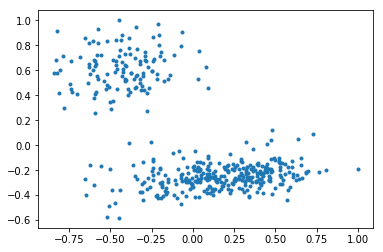

In [13]:
# Load pregenerated data
data = np.load("test_data.npy")
fig = plt.figure()  # plot a side section
ax = fig.add_subplot(111)
ax.plot(data[:,0], data[:,1], '.')
N, dim  = np.shape(data)
s = np.std(data)  # std
data_dev = np.std(data)
sigmaBuf = 0.0

In [9]:
"""If you want to tryout some other randomly generated data, uncomment below 

arguments to set:
genNrMin, genNrMin (int) : min and max of number of data points per cluster
dim (int) : dimension
nc (int) : number of clusters
"""

# # Generate fake data
# genNrmin = 60
# genNrmax = 250
# dim = 5 # dimension
# nc = 3  # clusters
# # complex_data = DataGen().datagen(dim, nc, sigma=0.4, nr = nr) * 2
# data = DataGen().datagen(dim, nc, sigma=0.4, minnr=genNrmin, maxnr=genNrmax) * 2
# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.plot(data[:,0], data[:,1], '.')
# N, dim  = np.shape(data)
# s = np.std(data)
# data_dev = np.std(data)
# sigmaBuf = 0.0
# print N, dim

'If you want to tryout some other randomly generated data, uncomment below \n\narguments to set:\ngenNrMin, genNrMin (int) : min and max of number of data points per cluster\ndim (int) : dimension\nnc (int) : number of clusters\n'

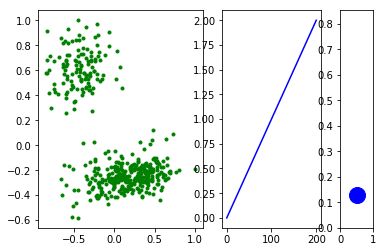

In [14]:
fig, axarr = plt.subplots(1,3, gridspec_kw = {'width_ratios':[5,3, 1]})
mngr = plt.get_current_fig_manager()
#mngr.window.setGeometry(0, 150, 1500, 800)
try:
    stopevent.set() 
except NameError:
    pass


# Setup Mode Explorer parameters: sigma, mass of particle, 
# r (resistence), dt (time step), nrSteps (step each movement)
sigma   = 0.3*s
mass    = 1.0 
r       = 0.999
dt      = 0.1
nrSteps = 256
sigmaBuf = sigma
lastpos = np.zeros(dim)
lastvel = np.zeros(dim)
maxamp = 1.
#--------------------------------------

# Set up plot
ix=0; iy=1
dsplt, = axarr[0].plot(data[:,ix], data[:,iy], "go", markersize=3)
trplt, = axarr[0].plot([], "r-", lw=5)
stplt, = axarr[0].plot([], "bo", markersize = 2)
sgplt, = axarr[1].plot([0,200],[0,2]  , "b-")
sigplt, = axarr[2].plot(0.5, sigma, 'bo', markersize=16)
axarr[2].axis([0, 1., 0, 2. * s])
plt.show(block=False)
fig.canvas.draw()
lock = False
#--------------------------------------

# Setup interactive plotting window to allow click and trigger. 
def on_click(event): 
    global lock; lock = True
    
def on_release(event): global lock; lock = False
    
def on_motion(event):
    global lock, sigma, mass, r, dt, nrSteps, sig, trj, lastpos, lastvel, sigmaBuf
    global lastTime, waitTime, maxamp
    if (lock):
        sigma = sigmaBuf
        pos2d = [event.xdata, event.ydata]
        lastposmf = data[nneighbor(data[:,[ix,iy]], pos2d),:]
        modeFound = False
        mfcnt = 0
        while(not modeFound and mfcnt<100):
            mfcnt +=1
            trjjunk, sigjunk, lastposmf, velJunk = PTSM(data, lastposmf, np.zeros(dim), sigma, mass, 0, 0.1, 100)
            if(np.linalg.norm(velJunk)<0.00001): modeFound=True
        modepot = potential(data, lastposmf, sigma)
        # print mfcnt, modepot
        if(mfcnt<100):
            lastvel = np.random.rand(dim) * 0.03 * sigma
            lastpos = lastposmf
            trjjj, sigjj, lastposjj, lastveljj = PTSM(data, lastpos, lastvel, sigma, mass, 1, dt, 4*nrSteps)
            maxamp = max(sigjj)
        else:
            maxamp = 10000
    time.sleep(0.02)
    
def handle_close(evt):
    stopevent.set() 

# Connect handlers. 
fig.canvas.mpl_connect('close_event', handle_close)
cidclk = fig.canvas.mpl_connect('button_press_event', on_click)
cidrel = fig.canvas.mpl_connect('button_release_event', on_release)
cidmov = fig.canvas.mpl_connect('motion_notify_event', on_motion)
#--------------------------------------

def proc(fifo, stopevent):
    global pos, r, sigma, mass, dt, nrSteps, lastpos, lastvel, trj, sig, ix, iy, axarr , alpha
    global maxamp, sr
    sent = 0
    t0 = time.time()
    while not stopevent.wait(0):
        nrSteps = 100 + int(random.random()*200)
        sent = sent + nrSteps
        trj, sig, lastpos, lastvel = PTSM(data, lastpos, lastvel, sigma, mass, r, dt, nrSteps)
        if(max(sig)>5*maxamp): sig = sig * 0 
        fifo.put(sig.astype(np.float32) / maxamp * 0.2)  # send signal to audio pipeline
        dti = sent/sr - (time.time()-t0-0.15)
        if(dti>0.12):   
            trplt.set_data(trj[:,ix], trj[:,iy])
            sgplt.set_data(np.arange(np.shape(sig)[0]), sig / max(abs(sig)))
            sigplt.set_data(0.5, sigma)
            axarr[0].draw_artist(axarr[0].patch)
            axarr[0].draw_artist(dsplt)
            axarr[0].draw_artist(trplt)
            axarr[1].draw_artist(axarr[1].patch)
            axarr[1].draw_artist(sgplt)
            fig.canvas.draw()
            fig.canvas.flush_events()
        dti = sent/sr - (time.time()-t0-0.03)
        if(dti>0): time.sleep(dti)  
    print "Mode Explorer Cleared."
    
    
stopevent = threading.Event()
producer = threading.Thread(name="Compute audio signal", target=proc, args=[fifo, stopevent])
producer.start()